## Predicting Energy Consumption from PJM (in MW)

Will also be comparing energy consumption from the East and West Regions of the United States as well as their projected energy consumption.

#### Functions & Imports

In [81]:
import pandas as pd
import seaborn as sbn
import plotly as plt
import scipy.optimize as sp
import math as m
import numpy as np

In [116]:
def newtint(x, y, xx):
    '''
    Function that uses a Newton Interpolating Polynomial
    Uses n-1 order polynomial given an n amount of data points to
    return a value of the dependent variable => yint at a provided
    independent variable => xx

    Input:
        x => array of independent variables
        y => array of dependent variables
        xx => desired x-value to interpolate

    Output:
        yint => interpolated value at xx
    '''

    # Check if the data is the same length
    n = len(x)
    if len(y) != n:
        return 'X and Y must be the same length.'

    # Initialize holder for calculations -> used to fill with dependent variables
    b = np.zeros((n, n))
    # Assign dependent variables to the 1st column of b for all rows in that column
    b[:, 0] = np.transpose(y)  # switch from input row to input column in b

    # Looping through each value in array to calculate the divided differences
    for j in range(1, n):
        for i in range(n-j):
            # Equation for divided differences based on next and prev points (see slides)
            b[i, j] = (b[i+1, j-1] - b[i, j-1]) / (x[i+j] - x[i])

    xt = 1
    yint = b[0, 0]

    # Solves for yint based on xx and divided differences
    for j in range(n-1):
        xt *= (xx - x[j])
        yint += b[0, j+1] * xt

    return yint

In [82]:
def lagrange(x, y, xx):
    '''
    Lagrange Interpolating Polynomial
    Uses n-1 order lagrange interpolating polynomial based on n number of data points to 
    return a value of the dependent variable yint given the independent variable xx

    Input:
        x => array of independent variable values
        y => array of dependent variable values
        xx => desired independent variable to interpolate

    Output:
        yint => interpolated value
    '''

    # Checking to see if everything is the same length
    n = len(x)
    if len(y) != n:
        return 'X and Y must be the same length'

    # Creating a placeholder
    s = 0

    for i in range(n):
        product = y[i]

        for j in range(n):
            if i != j:
                # This is the weighting equation => L (see slides)
                product *= (xx - x[j]) / (x[i] - x[j])
        s += product

    yint = s
    return yint

In [129]:
# Importing the csv files and assigning them as dataframes
dfw = pd.read_csv('PJMW_hourly.csv')
dfe = pd.read_csv('PJME_hourly.csv')

#### West-region

In [84]:
# Setting values to floats for 'PJMW_MW'
pd.to_numeric(dfw['PJMW_MW'])

usedYears = [] # Creating list of already used years
year = 0 # init the year iter var

valsPJMW = [] # Temp. list for averaging PJMW_MW vals per year
avgs = [] # avg PJMW vals
tmpAVG = 0

# Looping through 'dfw' to sort the data by year and create model
for row in dfw.itertuples():
    year = row[1][0:4] # ind1 -> tuple key | ind2 -> tuple value
    if year in usedYears:
        valsPJMW.append(row[2])
    elif year not in usedYears: # checks for start of new year
        if not usedYears: # check for start of loop
            usedYears.append(year) # appends curr year to usedYears list
            continue
        usedYears.append(year) # appends curr year to usedYears list
        tmpAVG = np.average(valsPJMW) # averages PJMW vals per year before clearing valsPJMW
        avgs.append(round(tmpAVG, 0))
        valsPJMW.clear() # clears PJMW vals for new year
        
usedYears.pop(-1) # removes year 2018 as there are few PJMW vals for it 
for i in range(len(usedYears)): # type converts usedYears vals from str -> int
    usedYears[i] = int(usedYears[i])

Regression, Interpolation, and Visualization

In [148]:
years = np.array(usedYears) # converting lists to array
avgPJMWs = np.array(avgs) # converting lists to array

p = np.polyfit(years, avgPJMWs, 4) # 2rd order regression
a = p[0] # parameters (coeff) of regression equation -> 1st param
b = p[1] # parameters (coeff) of regression equation -> 2nd param
c = p[2] # parameters (coeff) of regression equation -> 3nd param
d = p[3] # parameters (coeff) of regression equation -> 4th param
e = p[4] # parameters (coeff) of regression equation -> 5th param

In [149]:
def year_vs_PJMW_USWest(x): # defining equation obtained from regression of data
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

In [150]:
newPJMWs = [] # temp lists for new PJMWs from regression equation

startYear = 2018 # year to start regression from
endYear = startYear + len(usedYears) # year to end regression
newYears = np.linspace(startYear, endYear, 16) # year values as list

for i in range(len(usedYears)): # projected PJMWs per year
    newYears[i] = round(newYears[i], 0) # rounding years to whole num
    newPJMWs.append(round(year_vs_PJMW_USWest(round(newYears[i], 0)), 0))
    
newPJMWs = np.array(newPJMWs) # convert list to array

In [151]:
newPJMWs_Interpolated = [] # list for new PJMWs from lagrange interpolation

for i in range(len(usedYears)): # looping through each new year to interpolate the value
    newPJMWs_Interpolated.append(newtint(usedYears, avgs, newYears[i]))

<Axes: xlabel='Year', ylabel='PJMW'>

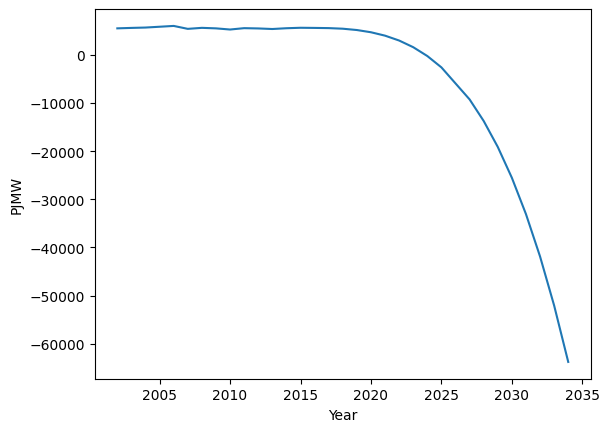

In [154]:
y = np.concatenate( # y-vals of graph -> PJMWs
    (avgPJMWs, newPJMWs),
    axis=0)

x = np.concatenate( # x-vals of graph -> Years
    (years, newYears),
    axis=0
)

y2 = np.concatenate(
    (avgPJMWs, newPJMWs_Interpolated),
    axis=0
)

yr_v_pjmw = {'Year':x, 'PJMW':y} # creating dictionary of labeled columns

plotDF = pd.DataFrame(yr_v_pjmw) # creating dataframe from dictionary for plotting

sbn.lineplot(data=plotDF, x='Year', y='PJMW')

#### East-region

In [89]:
# Using numerical methods to create a model from each dataset
